### Data sources

In order to validate the claims from [this](https://www.bloomberg.com/news/articles/2020-05-11/why-chicken-is-plentiful-during-the-pandemic-and-beef-is-not?srnd=premium&utm_medium=social&utm_source=twitter&utm_campaign=socialflow-organic&utm_content=markets&cmpid%3D=socialflow-twitter-markets&sref=XQtHDW1P) article, I pulled data from the FRED database, which pulls from the BLS. Each link will take you to the exact series that I downloaded here.

- [CPI (for inflation)](https://fred.stlouisfed.org/series/CPIAUCSL)
- [Poultry](https://fred.stlouisfed.org/series/APU0000706111)
- [Pork](https://fred.stlouisfed.org/series/APU0000FD3101)
- [Beef](https://fred.stlouisfed.org/series/APU0000703112)

The data from the fred does NOT go back to 1935, I'm not 100% sure where that historic data is coming from...

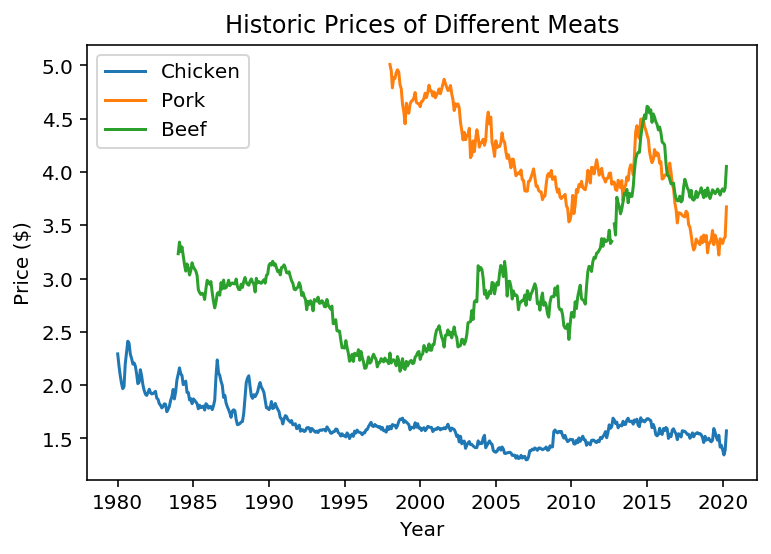

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date

%config InlineBackend.figure_format = 'retina'
%run ./helpers.ipynb

cpi = pd.read_csv('data/CPIAUCSL.csv')

# Get most recent cpi
MOST_RECENT = cpi.loc[cpi['DATE'] == cpi['DATE'].max(), 'CPIAUCSL'].values[0]

df = (
    beef()
    .pipe(pd.merge, chicken(), how='outer')
    .pipe(pd.merge, pork(), how='outer')
    .pipe(pd.merge, cpi, how='outer', on='DATE')
    .rename(columns={'APU0000703112':'beef',
                     'APU0000706111':'chicken',
                     'APU0000FD3101':'pork',
                     'CPIAUCSL':'cpi',
                     'DATE':'date'})
)

df['date'] = pd.to_datetime(df['date'])
df['beef'] = pd.to_numeric(df['beef'],errors='coerce')
df.sort_values(by=['date'], inplace=True)

df['new_pork'] = apply_adjust(df, 'pork', MOST_RECENT)
df['new_chicken'] = apply_adjust(df, 'chicken', MOST_RECENT)
df['new_beef'] = apply_adjust(df, 'beef', MOST_RECENT)

plt.plot(df['date'], df['new_chicken'], label='Chicken');
plt.plot(df['date'], df['new_pork'], label='Pork');
plt.plot(df['date'], df['new_beef'], label='Beef')
plt.legend(loc="upper left");
plt.xlabel("Year");
plt.ylabel("Price ($)")
plt.title("Historic Prices of Different Meats");

Quotes taken directly from the article

> 1. "poultry costs U.S. consumers 62% less in inflation-adjusted terms than it did in 1935"

> 2. "Pork, now also raised mostly at factory scale indoors, is 12% cheaper"

> 3. "Beef, which isn’t, costs 63% more."

In [78]:
def get_diff(df, var):
    oldest = df.loc[~df[var].isna(), 'date'].min()
    newest = df.loc[~df[var].isna(), 'date'].max()

    old = df.loc[df.date == oldest, 'new_{}'.format(var)].values[0]
    new = df.loc[df.date == newest, 'new_{}'.format(var)].values[0]
    ch = (new - old) / old
    print(
        '{}:\n  ${} --> ${}: {}'.format(var, round(old, 2), round(new, 2),
                                        round(ch, 2))
    )
    
get_diff(df, 'chicken')
get_diff(df, 'pork')
get_diff(df, 'beef')

chicken:
  $2.29 --> $1.57: -0.31
pork:
  $5.01 --> $3.67: -0.27
beef:
  $3.23 --> $4.05: 0.25
